# Vanishing Gradients

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

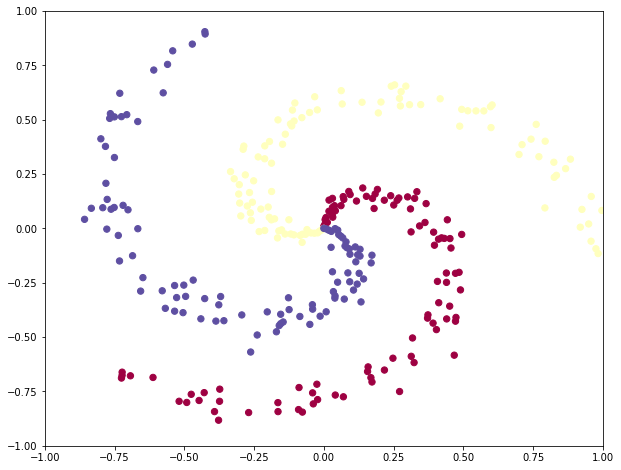

In [4]:
# generate random data -- not linearly separable
np.random.seed(42)
# number of points per class
N = 100 

# dimensionality
D = 2 

# number of classes
K = 3 

X = np.zeros((N*K, D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype="uint8")

for j in range(K):
    ix = range(N*j, N*(j+1))
    # radius
    r = np.linspace(0.0, 1, N)
    # theta
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1],c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

The sigmoid function "squahes" inputs to lie between 0 and 1. Unfortunately, this means that for inputs with sigmoid output close to 0 or 1, the gradient with respect to those inputs are close to zero. This leads to the phenomenon are close to zero, and the net does not learn well.

On the other hand, the relu function ($ \max(0, x) $) does not saturate with input size. Plot these functions to gain intuition.

In [5]:
def sigmoid(x):
    x = 1/(1 + np.exp(-x))
    
    return x

def sigmoid_grad(x):
    return x*(1 - x)

def relu(x):
    return np.maximum(0, x)

Let's try and see now how the two kinds of nonlinearities change deep neural net training in practice. Below, we build a very simple neural net with three layers (two hidden layers), for which you can swap out ReLu/Sigmoid linearities.

In [ ]:
# function to train a three layer neural net with either
# ReLu or Sigmoid nonlinearity via vanilla gradient descent

def three_layer_net(NONLINEARITY, X, y, model, step_size, reg):
    # parameter initialization
    
    h = model["h"]
    h2 = model["h2"]
    W1 = model["W1"]
    W2 = model["W3"]
    b1 = model["b1"]
    b2 = model["b2"]
    b3 = model["b3"]
    
    # some hyperparameters
    
    
    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    
    for i in range(50000):
        
        # FORWARD PROPAGATION
        if NONLINEARITY == "RELU":
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
            
        elif NONLINEARITY == "SIGM":
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
            
        exp_scores = np.exp(scores)
        # [N x K]
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # compute the loss:
        # average cross-entropy loss and regularization
        correct_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        
        if i % 1000 == 0:
            print("Iteration %d: loss %f" % (i, loss))
            
        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples), y] -=1
        dscores /= num_examples
        
        # BACK PROPAGATION
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        if NONLINEARITY == "RELU":
            
            # backprop ReLu nonlinearity here
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0